In [1]:
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
from scipy.ndimage.interpolation import zoom

import argparse
import numpy as np
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import os
import random
import shutil
import tensorflow as tf

In [2]:
flags = {
    'nums': {"train": 55000, "valid": 5000, "test": 10000},
    'all_names': ["train", "valid", "test"],
    'num_classes': 10,
}

In [3]:
def load_data():
    """ Download MNIST data from TensorFlow package, """
    mnist = input_data.read_data_sets("MNIST_data", one_hot=False)
    train_data = mnist.train.images
    test_data = mnist.test.images
    valid_data = mnist.validation.images
    train_label = mnist.train.labels
    test_label = mnist.test.labels
    valid_label = mnist.validation.labels
    all_data = [train_data, valid_data, test_data]
    all_labels = [train_label, valid_label, test_label]
    return all_data, all_labels

In [4]:
all_data, all_labels = load_data()
shutil.rmtree("MNIST_data")
all_names = flags['all_names']

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
all_data[0].shape

(55000, 784)

In [6]:
all_labels[0].shape

(55000,)

In [7]:
even_idx = np.where(np.equal(np.mod(all_labels[2], 2),0))
odd_idx = np.where(np.mod(all_labels[2], 2))

In [8]:
def gen_nCluttered(data, labels, im_dims, num_digits):
    # Initialize Blank image_out
    image_out = np.zeros([im_dims, im_dims])
    max_val = 0
    gt_boxes = list()
    
    for i in range(num_digits):
        # Choose digit
        idx = np.random.randint(len(labels))
        digit = data[idx,:].reshape((28,28))
        label = labels[idx]
        
        # Randomly Scale image
        h = np.random.randint(low=int(28/1.5), high=int(28*1.5))
        w = np.random.randint(low=int(28/1.5), high=int(28*1.5))
        digit = zoom(digit, (h/28, w/28))
        
        while(True):
            # Randomly choose location in image_out
            x = np.random.randint(low=0, high=im_dims - w)
            y = np.random.randint(low=0, high=im_dims - h)
        
            # Ensure that digit doesn't overlap with another
            if np.sum(image_out[y:y + h, x:x + w])==0:
                break
            
        # Insert digit into blank full size image and get max
        embedded = np.zeros([im_dims, im_dims])
        embedded[y:y + h, x:x + w] += digit
        max_val = max(embedded.max(), max_val)
        
        # Tighten box
        rows = np.sum(embedded, axis=0).round(1)
        cols = np.sum(embedded, axis=1).round(1)

        left = np.nonzero(rows)[0][0]
        right = np.nonzero(rows)[0][-1]
        upper = np.nonzero(cols)[0][0]
        lower = np.nonzero(cols)[0][-1]
        
        # If box is too narrow or too short, pad it out to >12
        width = right - left
        if width < 12:
            pad = np.ceil((12 - width)/2)
            left  = int(left - pad)
            right = int(right + pad)

        height = lower - upper
        if height < 12:
            pad = np.ceil((12 - height)/2)
            upper = int(upper - pad)
            lower = int(lower + pad)
            
        # Save Ground Truth Bounding boxes with Label in 4th position
        if labels[idx] == 0:  # Faster RCNN regards 0 as background, so change the label for all zeros to 10
            label = 10
        gt_box = [int(left), int(upper), int(right), int(lower), int(label)]
        
        # Save digit insertion
        image_out = image_out + embedded
        gt_boxes.append(gt_box)
    
    # Add in clutter patches
    for j in range(int(im_dims)):
        # Randomly select MNIST digit
        idx = np.random.randint(len(labels))
        fragment = data[idx,:].reshape(28,28)
        
        # Randomly select patch of selected digit
        px = np.random.randint(low=0, high=28 - 8)
        py = np.random.randint(low=0, high=28 - 8)

        # Randomly choose location to insert clutter
        x = np.random.randint(low=0, high=im_dims - 8)
        y = np.random.randint(low=0, high=im_dims - 8)
        
        # Insert digit fragment, but not on top of digits
        if np.sum(image_out[y:(y+8), x:(x+8)]) == 0:
            image_out[y:(y+8), x:(x+8)] += fragment[py:(py+8), px:(px+8)]
    
    # Normalize any over-saturated pixels
    image_out = np.clip(image_out, 0, max_val)
        
    # Subtract mean from image and scale to be between -1 and 1
    image_out -= image_out.mean()
    image_out = image_out / np.abs(image_out).max()

    return image_out, gt_boxes

In [9]:
im, gt = gen_nCluttered(all_data[0], all_labels[0], 128, 3)

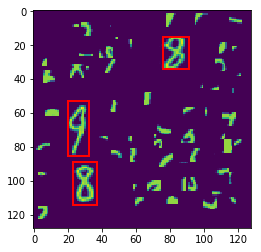

[[23, 89, 37, 114, 8], [76, 15, 91, 34, 8], [20, 53, 32, 85, 9]]


In [10]:
fig, ax = plt.subplots(1)
ax.imshow(im)

for gt_box in gt:
    height = gt_box[3] - gt_box[1]
    width = gt_box[2] - gt_box[0]
    rect = patches.Rectangle((gt_box[0], gt_box[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()
print(gt)

In [ ]:
gen_labels = np.array(gt)[:,4]
gen_evens = np.equal(np.mod(gen_labels, 2),0)

print(gen_labels)
print(gen_evens)

[8 8 9]
[ True  True False]


In [ ]:
data_dir = '../Data/HRI_clutteredMNIST/Test/Images/'

fig = plt.figure()
ims = []
for i in range(302,604):
    img = np.load(data_dir + 'img' + str(i) + '.npy')
    im = plt.imshow(img, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000)

ani.save(data_dir + '../control.mp4')